# Notebook 1 – Sentiment-Aware Research Pipeline
This notebook is self-contained and only needs the files shipped inside `ds_Advay_Sinha`. Run every cell in order inside Google Colab to regenerate the analytics, CSV outputs, and visuals used in the report.


**Workflow**
1. (Optional) Mount Google Drive if you stored this folder there.
2. Install the Python dependencies listed in `requirements.txt`.
3. Configure the data root so the notebook knows where `csv_files/` and `outputs/` live.
4. Load sentiment + trade data, clean timestamps, engineer features, and merge by nearest timestamp (72h tolerance).
5. Train the Logistic Regression, Random Forest, Gradient Boosting, and XGBoost classifiers; evaluate trend/contrarian/leverage strategies; export artifacts back into this folder.


In [1]:
try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
    print('Drive mounted. Update DATA_ROOT below if needed.')
except ModuleNotFoundError:
    print('Running outside Colab. Proceed to the next cell.')


Mounted at /content/drive
Drive mounted. Update DATA_ROOT below if needed.


In [2]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
plt.style.use('seaborn-v0_8-darkgrid')


In [3]:
DATA_ROOT = Path('/content/drive/MyDrive/ds_Advay_Sinha')
if not DATA_ROOT.exists():
    DATA_ROOT = Path.cwd()
CSV_DIR = DATA_ROOT / 'csv_files'
OUTPUT_DIR = DATA_ROOT / 'outputs'
CSV_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print('Using data root:', DATA_ROOT)
print('CSV directory:', CSV_DIR)
print('Outputs directory:', OUTPUT_DIR)


Using data root: /content/drive/MyDrive/ds_Advay_Sinha
CSV directory: /content/drive/MyDrive/ds_Advay_Sinha/csv_files
Outputs directory: /content/drive/MyDrive/ds_Advay_Sinha/outputs


In [4]:

def _to_snake(name: str) -> str:
    return name.strip().lower().replace(' ', '_').replace('/', '_')

sentiment = pd.read_csv(
    CSV_DIR / 'fear_greed_index.csv',
    parse_dates=['date'],
    infer_datetime_format=True,
)
sentiment = sentiment.sort_values('date').rename(columns={'date': 'sentiment_time'})
sentiment['classification'] = sentiment['classification'].fillna('Neutral')
score_map = {'Extreme Fear': -2, 'Fear': -1, 'Neutral': 0, 'Greed': 1, 'Extreme Greed': 2}
sentiment['sentiment_score'] = sentiment['classification'].map(score_map).fillna(0)
rolling = sentiment['sentiment_score'].rolling(window=5, min_periods=2)
sentiment['sentiment_score_z'] = (
    sentiment['sentiment_score'] - rolling.mean()
) / rolling.std(ddof=0)
sentiment['sentiment_score_lag1'] = sentiment['sentiment_score'].shift(1)
sentiment['sentiment_score_slope'] = sentiment['sentiment_score'].diff().fillna(0)
sentiment['sentiment_score_z'] = sentiment['sentiment_score_z'].replace([np.inf, -np.inf], 0).fillna(0)
sentiment['sentiment_score_lag1'] = sentiment['sentiment_score_lag1'].fillna(sentiment['sentiment_score'])
sentiment['sentiment_score_lag1'] = sentiment['sentiment_score_lag1'].fillna(0)

trades = pd.read_csv(CSV_DIR / 'historical_data.csv')
trades.columns = [_to_snake(col) for col in trades.columns]
trades['timestamp'] = pd.to_datetime(trades['timestamp_ist'], format='%d-%m-%Y %H:%M', errors='coerce')
numeric_cols = ['execution_price', 'size_tokens', 'size_usd', 'start_position', 'closed_pnl', 'fee']
for col in numeric_cols:
    trades[col] = pd.to_numeric(trades[col], errors='coerce')
trades['size_usd'] = trades['size_usd'].fillna(0)
trades['closed_pnl'] = trades['closed_pnl'].fillna(0)
trades['start_position'] = trades['start_position'].fillna(0)
trades['roi'] = trades['closed_pnl'] / trades['size_usd'].replace(0, np.nan)
trades['roi'] = trades['roi'].fillna(0)
trades['pnl_positive'] = (trades['closed_pnl'] > 0).astype(int)
trades['leverage_ratio'] = trades['size_usd'] / (trades['start_position'].abs() + 1e-6)
trades = trades.sort_values('timestamp').dropna(subset=['timestamp'])
print('Loaded', len(trades), 'trades and', len(sentiment), 'sentiment rows.')


/tmp/ipython-input-488458174.py:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  sentiment = pd.read_csv(


Loaded 211224 trades and 2644 sentiment rows.


In [5]:

sentiment_features = [
    'classification',
    'sentiment_score',
    'sentiment_score_lag1',
    'sentiment_score_slope',
    'sentiment_score_z'
]
merged = pd.merge_asof(
    trades,
    sentiment[['sentiment_time'] + sentiment_features],
    left_on='timestamp',
    right_on='sentiment_time',
    direction='backward',
    tolerance=pd.Timedelta('72H')
)
merged = merged.sort_values('timestamp')
merged['classification'] = merged['classification'].fillna('Neutral')
for col in sentiment_features[1:]:
    merged[col] = merged[col].fillna(0)
merged['abs_leverage'] = merged['leverage_ratio'].abs().clip(0, 50)
merged['notional_risk'] = merged['size_usd'].abs()
recent_window = merged['sentiment_score'].rolling(window=96, min_periods=12)
merged['recent_sentiment_z'] = (
    merged['sentiment_score'] - recent_window.mean()
) / recent_window.std(ddof=0)
merged['recent_sentiment_z'] = merged['recent_sentiment_z'].replace([np.inf, -np.inf], 0).fillna(0)
print('Merged dataset shape:', merged.shape)


Merged dataset shape: (211224, 28)


/tmp/ipython-input-1852931856.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  tolerance=pd.Timedelta('72H')


In [6]:

feature_cols = [
    'execution_price',
    'size_usd',
    'start_position',
    'fee',
    'abs_leverage',
    'sentiment_score',
    'sentiment_score_lag1',
    'sentiment_score_slope',
    'sentiment_score_z',
    'recent_sentiment_z'
]
X = merged[feature_cols].fillna(0)
y = merged['pnl_positive']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=300, max_depth=12, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.8,
        objective='binary:logistic',
        eval_metric='logloss',
        seed=42
    )
}
model_metrics = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:, 1]
    preds = (probs >= 0.5).astype(int)
    cm = confusion_matrix(y_test, preds).tolist()
    model_metrics[name] = {
        'accuracy': float(accuracy_score(y_test, preds)),
        'f1': float(f1_score(y_test, preds)),
        'roc_auc': float(roc_auc_score(y_test, probs)),
        'confusion': cm
    }
(CSV_DIR / 'model_metrics.json').write_text(json.dumps(model_metrics, indent=2))
model_metrics


{'LogisticRegression': {'accuracy': 0.5891932836763035,
  'f1': 0.03520865762360092,
  'roc_auc': 0.5741467159355371,
  'confusion': [[36861, 446], [25586, 475]]},
 'RandomForest': {'accuracy': 0.8028026764297437,
  'f1': 0.7122991205046738,
  'roc_auc': 0.9049712047184378,
  'confusion': [[35403, 1904], [10592, 15469]]},
 'GradientBoosting': {'accuracy': 0.6945145814922359,
  'f1': 0.5249104206547882,
  'roc_auc': 0.7659538348929985,
  'confusion': [[33316, 3991], [15367, 10694]]},
 'XGBoost': {'accuracy': 0.8138176997853807,
  'f1': 0.7500635539361071,
  'roc_auc': 0.908253447082144,
  'confusion': [[33867, 3440], [8358, 17703]]}}

In [7]:
def sharpe(returns: pd.Series) -> float:
    std = returns.std()
    if std == 0:
        return 0.0
    return float((returns.mean() / std) * np.sqrt(252))

def sortino(returns: pd.Series) -> float:
    downside = returns[returns < 0].std()
    if pd.isna(downside) or downside == 0:
        return 0.0
    return float((returns.mean() / downside) * np.sqrt(252))

def profit_factor(returns: pd.Series) -> float:
    gains = returns[returns > 0].sum()
    losses = returns[returns < 0].sum()
    return float(gains / abs(losses)) if losses != 0 else float('inf')

def expectancy(returns: pd.Series) -> float:
    return float(returns.mean())

trend_signal = np.sign(merged['sentiment_score'])
contrarian_signal = np.where(merged['classification'].str.contains('Extreme'), -trend_signal, 0)
leverage_signal = trend_signal * (1 + merged['abs_leverage'].clip(0, 5) / 5)

returns = {
    'Trend Following': merged['roi'] * trend_signal,
    'Contrarian Extremes': merged['roi'] * contrarian_signal,
    'Leverage Scaling': merged['roi'] * leverage_signal
}
strategy_metrics = {}
for name, ret in returns.items():
    ser = pd.Series(ret).replace([np.inf, -np.inf], 0).fillna(0)
    if len(ser) == 0:
        continue
    strategy_metrics[name] = {
        'Sharpe': sharpe(ser),
        'Sortino': sortino(ser),
        'Profit Factor': profit_factor(ser),
        'Expectancy': expectancy(ser)
    }
(CSV_DIR / 'strategy_metrics.json').write_text(json.dumps(strategy_metrics, indent=2))
strategy_metrics


{'Trend Following': {'Sharpe': 0.13790953741338294,
  'Sortino': 0.061897576356883206,
  'Profit Factor': 1.7056145001496106,
  'Expectancy': 0.007320441358531312},
 'Contrarian Extremes': {'Sharpe': -0.1348691221555608,
  'Sortino': -0.5227968330315573,
  'Profit Factor': 0.3529569091633816,
  'Expectancy': -0.007138444891016707},
 'Leverage Scaling': {'Sharpe': 0.14313392168881195,
  'Sortino': 0.06428815618055861,
  'Profit Factor': 1.6538593957319474,
  'Expectancy': 0.0076095703734574615}}

In [8]:
regime_metrics = (
    merged.groupby('classification')[['roi', 'closed_pnl', 'abs_leverage']]
    .agg(['mean', 'std', 'count'])
)
regime_metrics.columns = ['_'.join([lvl for lvl in col if lvl]).strip('_') for col in regime_metrics.columns.to_flat_index()]
regime_metrics = regime_metrics.reset_index().rename(columns={'classification': 'sentiment_classification'})
regime_metrics.to_csv(CSV_DIR / 'trader_regime_metrics.csv', index=False)
regime_metrics.head()


,sentiment_classification,roi_mean,roi_std,roi_count,closed_pnl_mean,closed_pnl_std,closed_pnl_count,abs_leverage_mean,abs_leverage_std,abs_leverage_count
0,Extreme Fear,0.004321,0.095705,21400,34.537862,1136.056091,21400,7.622297,16.376340,21400
1,Extreme Greed,0.040015,1.929376,39992,67.892861,766.828294,39992,8.806360,17.707219,39992
2,Fear,0.015409,0.072819,61837,54.290400,935.355438,61837,9.687317,18.364191,61837
3,Greed,0.019704,0.099754,50309,43.582684,1120.064348,50309,11.971284,20.198878,50309
4,Neutral,0.009936,0.175546,37686,34.307718,517.122220,37686,9.378230,18.195518,37686


In [9]:
account_summary = (
    merged.groupby('account')[['roi', 'closed_pnl', 'abs_leverage', 'pnl_positive']]
    .agg({'roi': 'mean', 'closed_pnl': 'sum', 'abs_leverage': 'mean', 'pnl_positive': 'mean'})
)
account_summary = account_summary.rename(columns={'pnl_positive': 'win_rate'})
account_summary['composite_score'] = (
    account_summary['roi'].rank(pct=True) * 0.4
    + account_summary['win_rate'].rank(pct=True) * 0.4
    + (1 - account_summary['abs_leverage'].rank(pct=True)) * 0.2
)
account_summary = account_summary.sort_values('composite_score', ascending=False)
account_summary.reset_index().to_csv(CSV_DIR / 'trader_rankings.csv', index=False)
account_summary.head()


,roi,closed_pnl,abs_leverage,win_rate,composite_score
account,,,,,
0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0,0.276064,72846.484272,3.576753,0.573141,0.93125
0x430f09841d65beb3f27765503d0f850b8bce7713,0.134140,416541.872341,0.437054,0.484236,0.91250
0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,0.027667,379095.406711,3.567088,0.810876,0.80000
0x2c229d22b100a7beb69122eed721cee9b24011dd,0.023537,168658.004994,3.395513,0.519914,0.76875
0xbaaaf6571ab7d571043ff1e313a9609a10637864,0.013435,940163.806220,0.216096,0.467582,0.70625


In [10]:

cluster_features = account_summary[['roi', 'win_rate', 'abs_leverage']].fillna(0)
scaler_clusters = StandardScaler()
cluster_scaled = scaler_clusters.fit_transform(cluster_features)
kmeans = KMeans(n_clusters=3, n_init=20, random_state=42)
labels = kmeans.fit_predict(cluster_scaled)
dbscan = DBSCAN(eps=0.8, min_samples=5)
dbscan_labels = dbscan.fit_predict(cluster_scaled)
cluster_df = account_summary.reset_index()[['account']].copy()
cluster_df['kmeans_cluster'] = labels
cluster_df['dbscan_cluster'] = dbscan_labels
cluster_df.to_csv(CSV_DIR / 'trader_behavior_clusters.csv', index=False)
cluster_df.head()


,account,kmeans_cluster,dbscan_cluster
0,0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0,0,-1
1,0x430f09841d65beb3f27765503d0f850b8bce7713,0,-1
2,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,0,-1
3,0x2c229d22b100a7beb69122eed721cee9b24011dd,0,0
4,0xbaaaf6571ab7d571043ff1e313a9609a10637864,0,0


In [11]:
threshold = merged.groupby('account')['abs_leverage'].median().median() * 2
alerts = (
    merged[merged['abs_leverage'] > threshold]
    .groupby('account')['abs_leverage']
    .max()
    .reset_index()
    .rename(columns={'abs_leverage': 'max_leverage_ratio'})
)
alerts.to_csv(CSV_DIR / 'leverage_alerts.csv', index=False)
alerts.head()


,account,max_leverage_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,50.0
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,50.0
2,0x271b280974205ca63b716753467d5a371de622ab,50.0
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,50.0
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,50.0


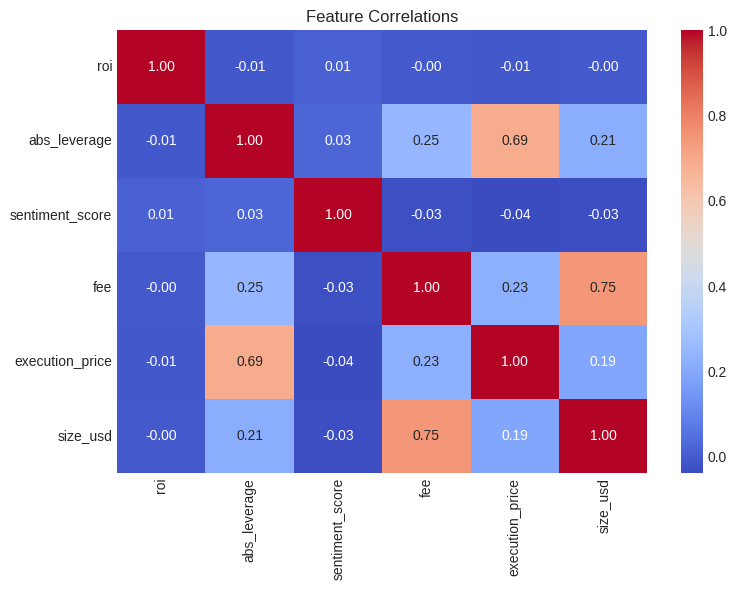

In [12]:
corr = merged[['roi', 'abs_leverage', 'sentiment_score', 'fee', 'execution_price', 'size_usd']].corr()
corr.to_csv(CSV_DIR / 'feature_correlations.csv')
plt.figure(figsize=(8, 6))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Feature Correlations')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'sentiment_performance_heatmap.png', dpi=200)
plt.show()


### Next steps
- Inspect the freshly generated CSV/JSON/PNG artifacts inside this folder.
- Update `ds_report.pdf` / `ds_report.txt` with new findings.
- Run `notebook_2.ipynb` for supplemental leverage/sentiment diagnostics if needed.
